# Predizione di siti web maligni o benigni

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Mario Ciccioni - mario.ciccioni@studio.unibo.it

## Fonti e Contributi
**Dataset:** https://github.com/urcuqui/WhiteHat/blob/master/Research/Web%20security/datasets/dataset.csv

**Autore e Progetto:** https://github.com/urcuqui/WhiteHat

## Descrizione del problema

Il problema nel determinare se un sito web e' sicuro o maligno e' il fatto che bisogna analizzarlo singolarmente e inserirlo in una black list.
Lo scopo di questo progetto e' l'implementazione e il confronto di modelli di classificazione che utilizzano tecniche di machine learning in grado di determinare la sicurezza o meno di un sito web, analizzado le caratteristiche del server e della rete.
Alcuni dati appartenenti ai siti web sono stati estrapolati da fonti sicure, mentre altri utilizzando tool addizionali come l'API di whois per determinare caratteristiche del server, come ad esempio *whois_country* che indica la posizione geografica del server di hosting del sito web.

## Aproccio:
* Esplorazione dei dati (EDA)
* Descrizione delle variabili
* Ottimizzazione delle variabili
* Grafici
* Preprocessing dei dati
* Addestramento modelli di machine learning
* Validazione dei risultati
* Conclusioni finali

### Import delle librerie base

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime
import hashlib

%matplotlib inline

## Data preprocessing and Analysis

Iniziamo caricando il dataset in un dataframe Pandas

In [2]:
data = pd.read_csv("./dataset/dataset.csv")

In [3]:
# clean up column names
data.columns = data.columns.str.strip().str.lower()

In [4]:
pd.set_option('display.max_columns', None)
data.head()

,url,url_length,number_special_characters,charset,server,content_length,whois_country,whois_statepro,whois_regdate,whois_updated_date,tcp_conversation_exchange,dist_remote_tcp_port,remote_ips,app_bytes,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,app_packets,dns_query_times,type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


### Significati delle colonne:

- `url`: url anonimizzato del sito web
- `url_length`: lunghezza dell'url non anonimizzato
- `number_special_characters`: numero dei caratteri speciali contenuti nell'url, come “/”, “%”, “#”, “&”, “. “, “=” 
- `charset`: variabile categorica che indica la codifica dei caratteri utilizzata dal sito web
- `server`: variabile categorica che indica il sistema operativo del server di hosting
- `content_length`: rappresenta la dimensione del contenuto del file header dell'html
- `whois_country`: variabile categorica che indica il paese ottenuto dalla risposta del server
- `whois_statepro`: variabile categorica che indica lo stato ottenuto dalla risposta del server
- `whois_regdate`: variabile di tipo "date" che indica la data di registrazione del server
- `whois_updated_date`: variabile di tipo "date" che indica l'ultima data di aggiornamento del server
- `tcp_conversation_exchange`: indica il numero di pacchetti TCP scambiati tra client e server
- `dist_remote_tcp_port`: indica il numero di porte identificate non TCP
- `remote_ips`: indica il numero totale di connessioni IP dirette al client
- `app_bytes`: indica il numero di byte trasferiti
- `source_app_packets`: indica i pacchetti trasferiti dal client al server
- `remote_app_packets`: indica i pacchetti ricevuti dal server
- `source_app_bytes`: indica il numero di byte trasferiti dal client al server
- `remote_app_bytes`: indica il numero di byte ricevuti dal server
- `app_packets`: indica il numero totale di pacchetti IP traferiti durante la connessione
- `dns_query_times`: indica il numero di pacchetti DNS generati durante la comunicazione tra client e server
- `type`: variabile categorica, 1 sito web maligno e 0 sito web benigno

*Tutte le variabili precedute da "whois_" sono state ottenute utilizzando l'API di whois*

In [5]:
r, c = data.shape
print("number of rows = ", r)
print("number of columns = ", c)

number of rows =  1781
number of columns =  21


Analizziamo ora il tipo di dato di ogni variabile del dataset

In [6]:
data.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   url                        1781 non-null   object 
 1   url_length                 1781 non-null   int64  
 2   number_special_characters  1781 non-null   int64  
 3   charset                    1781 non-null   object 
 4   server                     1780 non-null   object 
 5   content_length             969 non-null    float64
 6   whois_country              1781 non-null   object 
 7   whois_statepro             1781 non-null   object 
 8   whois_regdate              1781 non-null   object 
 9   whois_updated_date         1781 non-null   object 
 10  tcp_conversation_exchange  1781 non-null   int64  
 11  dist_remote_tcp_port       1781 non-null   int64  
 12  remote_ips                 1781 non-null   int64  
 13  app_bytes                  1781 non-null   int64

Noto che molte varibili sono considerate di tipo object perche' stringhe ma so che sono variabili categoriche, percio' le rendo tali ottimizzando l'utilizzo di memoria.

In [7]:
data['url'] = data.url.astype('category')
data['charset'] = data.charset.astype('category')
data['server'] = data.server.astype('category')
data['whois_country'] = data.whois_country.astype('category')
data['whois_statepro'] = data.whois_statepro.astype('category')

Mentre le date le trasformo nella loro rappresentazione numerica (Unix Time Representation) in quanto piu' facili da manipolare quando dovro' applicare algoritmi di ml. Decido di mantenere le colonne che contengono le date, invece di eliminarle, perche' possono fornire informazioni importanti in quanto alcune di esse, ad esempio quella che indica la data di registrazione del server e' molto influente in quanto, se molto recente, puo' facilmente trattarsi di un sito web maligno dal punto di vista del buon senso.

In [8]:
# There are two datetime formats that are processed with different masks
# and some incorrect values ('None', 'b', '0') that we replace with -1

regdate_ts = []

for date in data.whois_regdate.values:
    if date not in ['None', 'b', '0']:
        try:
            regdate_ts.append(int(datetime.strptime(date, '%d/%m/%Y %H:%M').timestamp()))
        except ValueError:
            regdate_ts.append(int(datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.0Z').timestamp()))
    else:
        regdate_ts.append(-1)
        
upd_ts = []

for date in data.whois_updated_date.values:
    if date not in ['None', 'b', '0']:
        try:
            upd_ts.append(int(datetime.strptime(date, '%d/%m/%Y %H:%M').timestamp()))
        except ValueError:
            upd_ts.append(int(datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.0Z').timestamp()))
    else:
        upd_ts.append(-1)

In [9]:
# replace the original date variables with unix time ones
data['regdate_ts'] = regdate_ts
data['upd_ts'] = upd_ts

data = data.drop(columns=['whois_regdate', 'whois_updated_date']) # dropping original string features
data

,url,url_length,number_special_characters,charset,server,content_length,whois_country,whois_statepro,tcp_conversation_exchange,dist_remote_tcp_port,remote_ips,app_bytes,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,app_packets,dns_query_times,type,regdate_ts,upd_ts
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,7,0,2,700,9,10,1153,832,9,2.0,1,1444494060,-1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0,-1,-1
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,0,0,0,0,0,0,0,0,0,0.0,0,-1,-1
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,31,22,3,3812,39,37,18784,4380,39,8.0,0,876189600,1378939500
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,57,2,5,4278,61,62,129889,4586,61,4.0,0,831852000,1491861600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,M4_48,194,16,UTF-8,Apache,NaN,ES,Barcelona,0,0,0,0,0,3,186,0,0,0.0,1,1221602400,1472767200
1777,M4_41,198,17,UTF-8,Apache,NaN,ES,Barcelona,0,0,0,0,0,2,124,0,0,0.0,1,1221602400,1472767200
1778,B0_162,201,34,utf-8,Apache/2.2.16 (Debian),8904.0,US,FL,83,2,6,6631,87,89,132181,6945,87,4.0,0,919033200,1436911200
1779,B0_1152,234,34,ISO-8859-1,cloudflare-nginx,NaN,US,CA,0,0,0,0,0,0,0,0,0,0.0,0,891381600,1481238000


In [10]:
data.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   url                        1781 non-null   category
 1   url_length                 1781 non-null   int64   
 2   number_special_characters  1781 non-null   int64   
 3   charset                    1781 non-null   category
 4   server                     1780 non-null   category
 5   content_length             969 non-null    float64 
 6   whois_country              1781 non-null   category
 7   whois_statepro             1781 non-null   category
 8   tcp_conversation_exchange  1781 non-null   int64   
 9   dist_remote_tcp_port       1781 non-null   int64   
 10  remote_ips                 1781 non-null   int64   
 11  app_bytes                  1781 non-null   int64   
 12  source_app_packets         1781 non-null   int64   
 13  remote_app_packets         1781 n

Come si puo' notare ho ottenuto una diminuzione sostanziale di memoria (della meta'). In questo dataset ovviamente non e' stata una operazione indispensabile in quanto esso era gia' piccolo in partenza, ma in caso di utilizzo di dataset piu' grandi questo passaggio e' fondamentale.

A questo punto dobbiamo fare una verifica approfondita sulla qualita' dei dati, quindi quanti valori nulli sono presenti nel dataset in questione. Nei dati sono presenti anche valori None, decido di tenerli valutandoli come informazioni che non sono state fornite dal sito web.

In [11]:
null_values = data.isnull().sum()
print(null_values)

url                            0
url_length                     0
number_special_characters      0
charset                        0
server                         1
content_length               812
whois_country                  0
whois_statepro                 0
tcp_conversation_exchange      0
dist_remote_tcp_port           0
remote_ips                     0
app_bytes                      0
source_app_packets             0
remote_app_packets             0
source_app_bytes               0
remote_app_bytes               0
app_packets                    0
dns_query_times                1
type                           0
regdate_ts                     0
upd_ts                         0
dtype: int64


Noto che le uniche 3 variabili che possiedono valori nulli sono server, content_lenght (ne possiede quasi la meta' di valori nulli) e dns_query_times.

Per notarlo meglio plotto i valori in un grafico a barre:

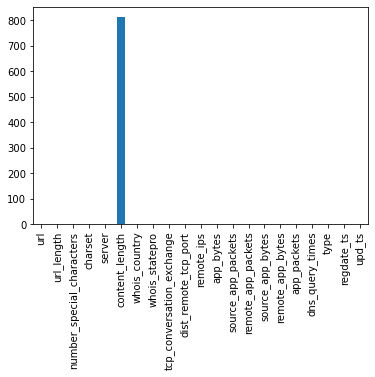

In [12]:
data.isnull().sum().plot.bar();

Decido di sostituire i valori Nan con il valore piu' comune di ogni variabile

In [13]:
for col in data.drop(columns=['type']).columns:
    if data[col].isna().any():
        mode = data[col].mode().iloc[0]
        print(f"{col} contains NAs, replacing with {mode}")
        data[col] = data[col].fillna(mode)

server contains NAs, replacing with Apache
content_length contains NAs, replacing with 324.0
dns_query_times contains NAs, replacing with 0.0


Verifico che non ci siano piu' valori nulli presenti tra i dati

In [14]:
null_values = data.isnull().sum()
print(null_values)

url                          0
url_length                   0
number_special_characters    0
charset                      0
server                       0
content_length               0
whois_country                0
whois_statepro               0
tcp_conversation_exchange    0
dist_remote_tcp_port         0
remote_ips                   0
app_bytes                    0
source_app_packets           0
remote_app_packets           0
source_app_bytes             0
remote_app_bytes             0
app_packets                  0
dns_query_times              0
type                         0
regdate_ts                   0
upd_ts                       0
dtype: int64


Genero le statistiche descrittive dell'intero dataset:

In [15]:
data.describe()

,url_length,number_special_characters,content_length,tcp_conversation_exchange,dist_remote_tcp_port,remote_ips,app_bytes,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,app_packets,dns_query_times,type,regdate_ts,upd_ts
count,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1781.000000,1781.000000,1.781000e+03,1.781000e+03
mean,56.961258,11.111735,6528.063448,16.261089,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.262212,0.121280,9.416509e+08,1.346128e+09
std,27.555586,4.549896,27431.514817,40.500975,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930520,0.326544,3.094688e+08,3.931642e+08
min,16.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00
25%,39.000000,8.000000,324.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,8.471664e+08,1.440022e+09
50%,49.000000,10.000000,324.000000,7.000000,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000,9.754524e+08,1.467756e+09
75%,68.000000,13.000000,3063.000000,22.000000,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000,1.118354e+09,1.483398e+09
max,249.000000,43.000000,649263.000000,1194.000000,708.000000,17.000000,2.362906e+06,1198.000000,1284.000000,2.060012e+06,2.362906e+06,1198.000000,20.000000,1.000000,1.492121e+09,1.493417e+09


Visualizzo la statistiche descrittive della variabile "number_special_characters" relative alle due classi da predire. Già da qui posso capire che questa varibile è molto influente nel predire se un sito web è maligno o benigno.

In [16]:
data["number_special_characters"].groupby(data["type"]).describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
0,1565.0,10.637061,4.027070,6.0,8.0,10.0,12.0,43.0
1,216.0,14.550926,6.316254,5.0,10.0,12.0,20.0,36.0


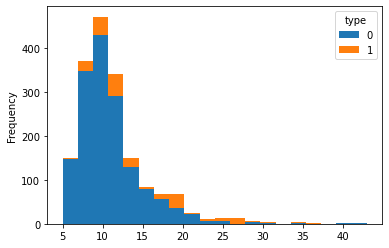

In [17]:
data.pivot(columns="type")["number_special_characters"].plot.hist(bins=20, stacked=True);

Plotto un grafico a torta per visualizzare gli stati di tutti i siti web

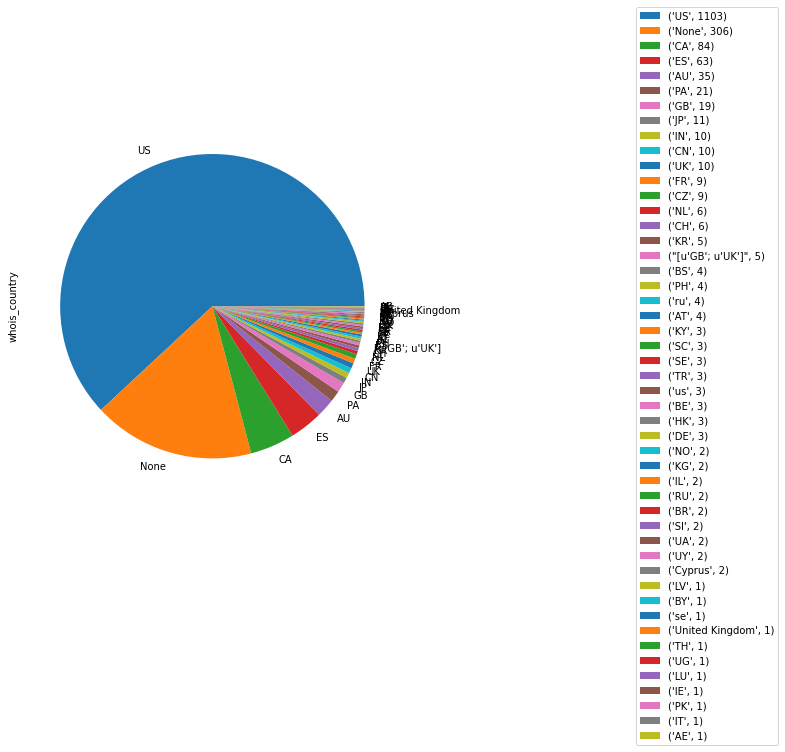

In [18]:
data["whois_country"].value_counts().plot.pie(figsize = (7,7));
plt.legend(labels = list(zip(data["whois_country"].value_counts().index, data["whois_country"].value_counts())), loc = "best", bbox_to_anchor = (2, 1.3));

Dal seguente grafico possiamo notare che la maggioranza dei siti web presenti del dataset (1103) e' US seguito da CA e ES, tutti gli altri stati presenti sono una piccola parte del totale. Numeri prevedibili in quanto l'esperimento e' stato effettuato geograficamente in US. 

Plotto la matrice di correlazione che mi permette di visualizzare in modo semplice se ci sono delle variabili in stretta correlazione tra di loro.

C:\Users\mario\anaconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


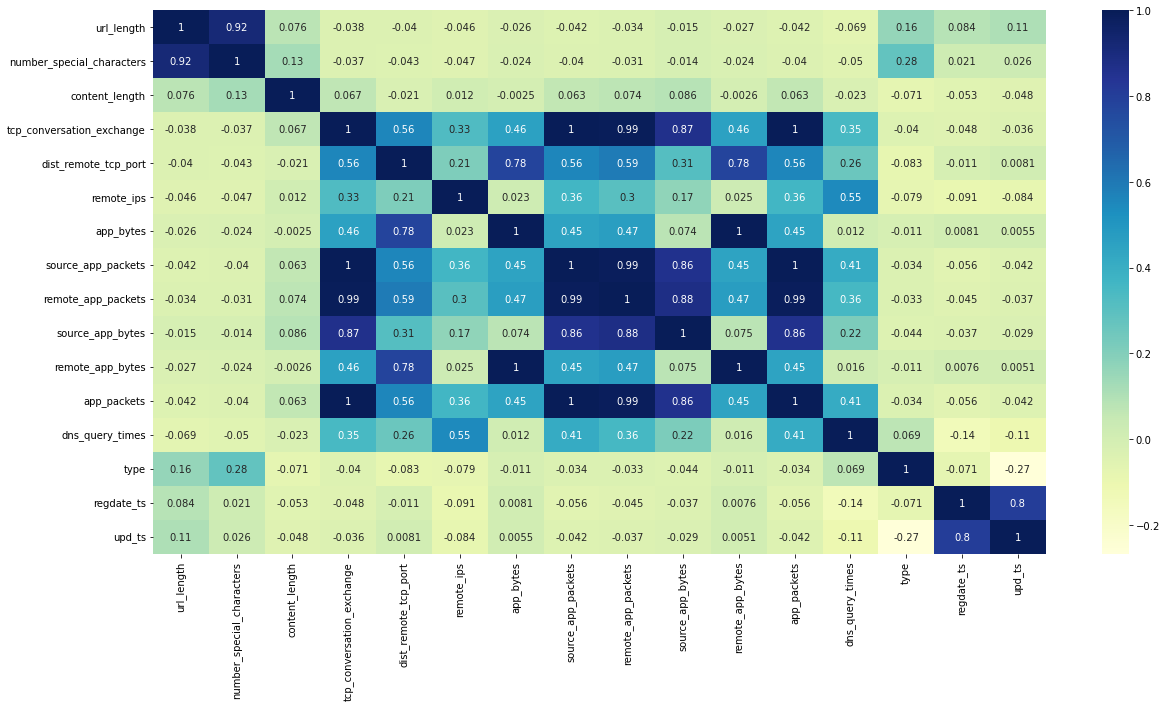

In [19]:
import seaborn as sns

plt.figure(figsize=(20,10))
sns.heatmap(data=data.corr(), cmap='YlGnBu', annot=True);

Noto che alcune variabili sono in stretta correlazione tra di loro come ad esempio il numero di pacchetti traferiti tra client e server ma soprattutto la lunghezza dell'url e il numero di caratteri speciali.

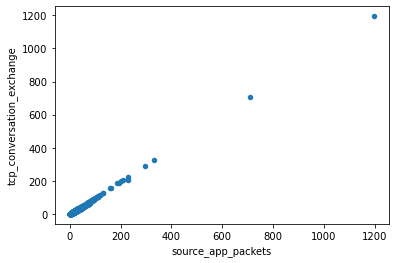

In [20]:
data.plot.scatter('source_app_packets', 'tcp_conversation_exchange');

In [21]:
class_color_map = {0: "blue", 1: "red"}
class_colors = data["type"].map(class_color_map)
class_colors.tail()

1776     red
1777     red
1778    blue
1779    blue
1780    blue
Name: type, dtype: object

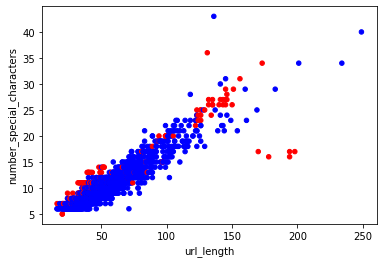

In [22]:
data.plot.scatter('url_length', 'number_special_characters', c=class_colors);

Inoltre noto che la variabile content_length non e' in correlazione con nessun altra e quindi, anche tenendo conto che possedeva molti valori nulli, la elimino

In [23]:
data = data.drop('content_length', axis=1)

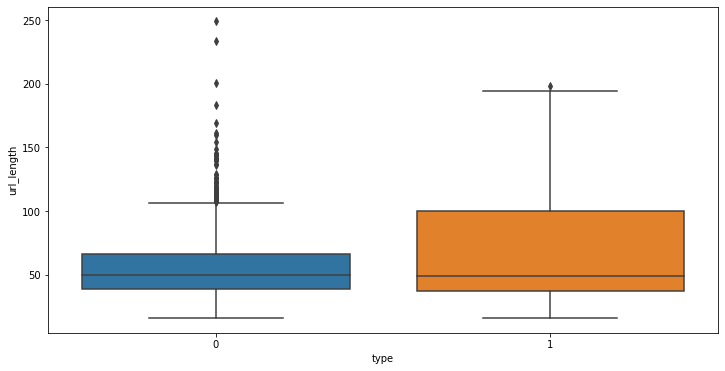

In [24]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x='type', y='url_length');

Mettendo in correlazione il tipo di sito web con la lunghezza del suo url noto che quelli maligni hanno mediamente una lunghezza maggiore dell'url 

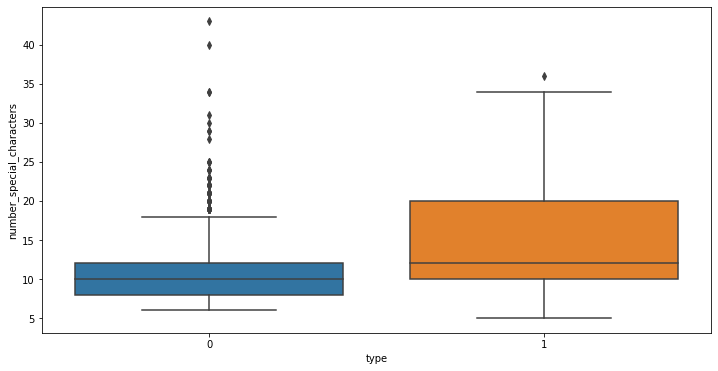

In [25]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x='type', y='number_special_characters');

Ancora piu' significativo e' il numero di caratteri speciali contenuti dell'url che e' molto maggiore negli url maligni.

Ora faccio una comparazione sul numero dei siti web maligni e benigni presenti del dataset

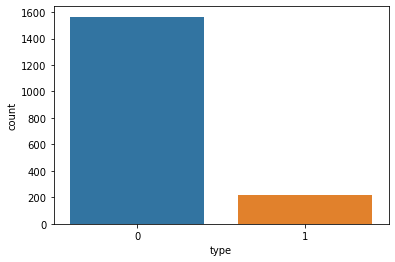

In [26]:
sns.countplot(x="type",data=data); 

Noto che il numero di siti web begnini è di molto superirore a quelli maligni (mi trovo di fronte ad un imbalanced dataset), sicuramente rispecchia la realtà dei fatti (almeno nel clear web) per cui c'era da aspettarselo.

In [27]:
data.head()

,url,url_length,number_special_characters,charset,server,whois_country,whois_statepro,tcp_conversation_exchange,dist_remote_tcp_port,remote_ips,app_bytes,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,app_packets,dns_query_times,type,regdate_ts,upd_ts
0,M0_109,16,7,iso-8859-1,nginx,None,None,7,0,2,700,9,10,1153,832,9,2.0,1,1444494060,-1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0,-1,-1
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,None,None,0,0,0,0,0,0,0,0,0,0.0,0,-1,-1
3,B0_113,17,6,ISO-8859-1,nginx,US,AK,31,22,3,3812,39,37,18784,4380,39,8.0,0,876189600,1378939500
4,B0_403,17,6,UTF-8,None,US,TX,57,2,5,4278,61,62,129889,4586,61,4.0,0,831852000,1491861600


A questo punto ho un dataset che contiene variabili numeriche e categoriche.
Le divido in due liste (numeric_vars e categorical_vars) per poi trattarle in modo diverso prima di addestrare i modelli.

In [28]:
numeric_vars = [
    "url_length", "number_special_characters", "tcp_conversation_exchange",
    "dist_remote_tcp_port", "remote_ips", "app_bytes", "source_app_packets", "remote_app_packets", 
    "source_app_bytes", "remote_app_bytes", "app_packets", "dns_query_times", "regdate_ts", "upd_ts"
]

categorical_vars = [
    "charset", "server", "whois_country", "whois_statepro"
]

## Perceptron

Per prima cosa valuto l'addrestramento di due semplici modelli (scelta sempre consigliata per valutare se anche un modello non troppo complesso funziona gia' bene) Il primo e' un modello lineare che si basa sulla divisione delle due classi con una retta in modo da predirre la classe di appartenenza di un sito web (maligno o benigno) chiamato **Perceptron**, mentre il secondo e' **LogisticRegression**. 

*Solo per l'addestramento di questi due primi modelli non applico la Stratified K-Fold Cross Validation mantenedo il piu' semplice possibile il flusso di codice.*

In [29]:
X = data.drop('type', axis=1)
y = data['type']

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Perceptron

model1 = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric",     StandardScaler(), numeric_vars),
        ("categorical", OneHotEncoder(handle_unknown='ignore'),  categorical_vars)
    ])),
    ("percepton", Perceptron(random_state=42))
])

In [32]:
model1.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['url_length',
                                                   'number_special_characters',
                                                   'tcp_conversation_exchange',
                                                   'dist_remote_tcp_port',
                                                   'remote_ips', 'app_bytes',
                                                   'source_app_packets',
                                                   'remote_app_packets',
                                                   'source_app_bytes',
                                                   'remote_app_bytes',
                                                   'app_packets',
                                                   'dns_query_times',
                                                   'regdate_ts', 'upd_ts']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['charset', 'server',
                                                   'whois_country',
                                                   'whois_statepro'])])),
                ('percepton', Perceptron(random_state=42))])

In [33]:
model1.named_steps['percepton'].coef_[0].size

402

In [34]:
model1.named_steps['percepton'].intercept_[0].size

1

In [35]:
model1.named_steps['percepton'].coef_[0]

array([ -9.71058716,  11.82255363,   3.86402889, -28.59450523,
        -2.4946585 ,   1.0847021 ,   4.14762819,  -6.18594665,
       -17.43236362,   1.07864346,   4.14762819,   5.91057667,
         0.31669169,  -8.36786776,  -9.        ,   0.        ,
       -12.        , -10.        ,  -8.        , -18.        ,
         3.        ,  -4.        ,   0.        ,  -7.        ,
         0.        ,  -2.        ,   0.        ,   0.        ,
         4.        ,  -3.        ,   0.        ,  15.        ,
         3.        ,   0.        ,   0.        ,   0.        ,
        -1.        ,   5.        ,  -1.        ,  -1.        ,
        -1.        ,  -1.        ,   4.        ,   0.        ,
         0.        ,   0.        ,  -7.        ,   0.        ,
       -16.        ,   0.        ,  -1.        ,  -1.        ,
         3.        ,  -1.        ,   0.        ,   0.        ,
        -1.        ,  -1.        ,  -4.        ,   0.        ,
         5.        ,   0.        ,  -5.        ,  -3.  

In [36]:
model1.named_steps['percepton'].intercept_[0]

-0.5800000000000003

In [37]:
model1.score(X_test, y_test)

0.9336734693877551

Questo modello riesce ad ottenere un accuratezza del 93%, non male tenendo conto che è un semplice modello lineare. 

Che questo modello potesse ottenere un risultato molto buono poteva essere previsto in quanto questo dataset possiede molte variabili, per cui e' piu' facile separare le classi linearmente.

## Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

model3 = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric",     StandardScaler(), numeric_vars),
        ("categorical", OneHotEncoder(handle_unknown='ignore'),  categorical_vars)
    ])),
    ("logreg", LogisticRegression(random_state=42, C=1)) # the default regolarization is the best
])

In [39]:
model3.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['url_length',
                                                   'number_special_characters',
                                                   'tcp_conversation_exchange',
                                                   'dist_remote_tcp_port',
                                                   'remote_ips', 'app_bytes',
                                                   'source_app_packets',
                                                   'remote_app_packets',
                                                   'source_app_bytes',
                                                   'remote_app_bytes',
                                                   'app_packets',
                                                   'dns_query_times',
                                                   'regdate_ts', 'upd_ts']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['charset', 'server',
                                                   'whois_country',
                                                   'whois_statepro'])])),
                ('logreg', LogisticRegression(C=1, random_state=42))])

Da questi valori capisco quali sono le colonne più importanti.

In [40]:
model3.score(X_test, y_test)

0.9523809523809523

In [41]:
print(model3.named_steps['logreg'].coef_[0])

[-1.13202172e+00  1.32505724e+00  2.44846124e-02 -2.58998949e+00
 -3.98303733e-01 -6.24830726e-02  1.24874981e-01 -3.38780982e-02
 -8.80418791e-01 -5.97076851e-02  1.24874981e-01  1.18243994e+00
  8.90623258e-01 -1.45239911e+00  1.03379232e-01 -2.17449927e-02
 -1.46128478e-02  1.22042714e-01 -2.24281124e-01 -5.79729669e-01
  6.94075769e-01 -7.87845142e-02 -1.00102416e-02 -2.94772675e-01
 -3.77618517e-02 -7.25718879e-02 -1.51775025e-02 -4.90637788e-02
  2.97397741e-01 -4.12340240e-01 -1.06278060e-02  8.82031239e-01
  6.94075769e-01 -1.05554316e-04 -1.11534726e-02 -5.34283684e-02
 -6.17724344e-02  3.94883997e-01 -3.16725078e-02 -1.32063814e-02
 -1.13347605e-01 -9.44102349e-02  1.42278729e+00 -2.20851108e-02
 -6.97083052e-03 -2.13471802e-02 -5.82312889e-01 -1.70279629e-02
 -9.19905206e-01 -9.67465733e-03 -3.46299208e-02 -1.28876865e-01
  5.59440673e-01 -4.71099029e-02 -4.46891593e-02 -4.12861656e-02
 -3.26594493e-02 -8.97730269e-02 -2.38435681e-01 -1.48969070e-02
  1.32989011e-01 -9.78807

In [42]:
print(model3.named_steps['logreg'].intercept_[0])

-2.6421799332137534


Questo modello ha un'accuratezza del 95%.

## Random Forest

Ora addrestro un altro modello chiamato **RandomForestClassifier**, in letteratura funziona molto bene con datatset con queste caratteristiche e solo 2 possibili classi da predirre.

*E' una versione estesa degli alberi decisionali in modo ottimizzato*

Uso la Stratified K-fold cross validation in modo tale da ottenere dei risultati calcolati usando il 100% dei dati presenti nel dataset e non risultati dipendenti dal gruppo di dati che fornisco al modello in fase di training. Inoltre mi da la garanzia che le due classi siano bilanciate in ogni fold.

In [43]:
from sklearn.model_selection import KFold, StratifiedKFold

skf = StratifiedKFold(5, shuffle=True, random_state=42)

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, fbeta_score, make_scorer, precision_score, recall_score 

model2 = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric",     StandardScaler(), numeric_vars),
        ("categorical", OneHotEncoder(handle_unknown='ignore'),  categorical_vars)
    ])),
    ("rfc", RandomForestClassifier(random_state=42))
])

grid = {
    "rfc__n_estimators": [25, 50, 100, 150],
    "rfc__max_features": ["sqrt", "log2", None],
    "rfc__max_depth": [3, 6, 9],
    "rfc__max_leaf_nodes": [3, 6, 9],
    "rfc__class_weight": [{0:1,1:1}, {0:1,1:3}, {0:1,1:5}]
}

gs = GridSearchCV(model2, param_grid=grid, cv=skf)

gs.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['url_length',
                                                                          'number_special_characters',
                                                                          'tcp_conversation_exchange',
                                                                          'dist_remote_tcp_port',
                                                                          'remote_ips',
                                                                          'app_bytes',
                                                                          'source_app_packets',
                                                                          'remote_app_packets',
                                                                          'source_app_bytes',
                                                                          '...
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['charset',
                                                                          'server',
                                                                          'whois_country',
                                                                          'whois_statepro'])])),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rfc__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 3},
                                               {0: 1, 1: 5}],
                         'rfc__max_depth': [3, 6, 9],
                         'rfc__max_features': ['sqrt', 'log2', None],
                         'rfc__max_leaf_nodes': [3, 6, 9],
                         'rfc__n_estimators': [25, 50, 100, 150]})

In [45]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__class_weight,param_rfc__max_depth,param_rfc__max_features,param_rfc__max_leaf_nodes,param_rfc__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
299,0.280051,0.004483,0.021942,4.156970e-07,"{0: 1, 1: 5}",9,sqrt,9,150,"{'rfc__class_weight': {0: 1, 1: 5}, 'rfc__max_...",0.955182,0.957865,0.946629,0.941011,0.966292,0.953396,0.008816,1
261,0.100332,0.001844,0.011569,4.893574e-04,"{0: 1, 1: 5}",6,sqrt,9,50,"{'rfc__class_weight': {0: 1, 1: 5}, 'rfc__max_...",0.949580,0.966292,0.943820,0.943820,0.957865,0.952276,0.008694,2
178,1.151948,0.022315,0.020880,1.738788e-03,"{0: 1, 1: 3}",6,None,9,100,"{'rfc__class_weight': {0: 1, 1: 3}, 'rfc__max_...",0.949580,0.957865,0.952247,0.941011,0.960674,0.952276,0.006869,2
179,1.535646,0.024380,0.022540,1.029457e-03,"{0: 1, 1: 3}",6,None,9,150,"{'rfc__class_weight': {0: 1, 1: 3}, 'rfc__max_...",0.949580,0.957865,0.949438,0.946629,0.955056,0.951714,0.004113,4
298,0.190684,0.005472,0.016962,1.533133e-05,"{0: 1, 1: 5}",9,sqrt,9,100,"{'rfc__class_weight': {0: 1, 1: 5}, 'rfc__max_...",0.949580,0.957865,0.943820,0.943820,0.960674,0.951152,0.007010,5


Da quest'ultima tabella noto che questo modello e' molto robusto e stabile perche' l'accuratezza cambia di poco in base alla fold che gli passo. Con la fold migliore arriva ad ottenere un'accuratezza del ~97%. In media il modello ha un'accuratezza del ~95% nel caso miglire.

In [46]:
print(gs.best_params_)

{'rfc__class_weight': {0: 1, 1: 5}, 'rfc__max_depth': 9, 'rfc__max_features': 'sqrt', 'rfc__max_leaf_nodes': 9, 'rfc__n_estimators': 150}


Gli iperparametri migliori sono quindi: class_weight: {0: 1, 1: 5}, max_depth: 9, max_features: 'sqrt'
                                        max_leaf_nodes: 9, n_estimators: 150

In [47]:
print(gs.best_estimator_)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['url_length',
                                                   'number_special_characters',
                                                   'tcp_conversation_exchange',
                                                   'dist_remote_tcp_port',
                                                   'remote_ips', 'app_bytes',
                                                   'source_app_packets',
                                                   'remote_app_packets',
                                                   'source_app_bytes',
                                                   'remote_app_bytes',
                                                   'app_packets',
                                                   'dns_query_times',
                                                   'regdate_ts', 'upd_ts']),
              

Nonostante questo ottimo risultato ottenuto bisogna fare attenzione. Non è sempre detto che l'accuratezza mostri quanto è preciso un modello di classificazione, soprattutto perchè mi trovo davanti ad un imbalanced dataset.
Per questo è bene non fidarsi dell'accuratezza perchè può non essere un parametro affidabile e quindi è possibile confrontare le classi predette dal classificatore e confrontarle con quelle reali ottenendo una matrice di confusione e valutare meglio il modello. 

In [48]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(model2, X, y, cv=skf)
conf_mat = confusion_matrix(y, y_pred)

Visualizzo la matrice di confusione.

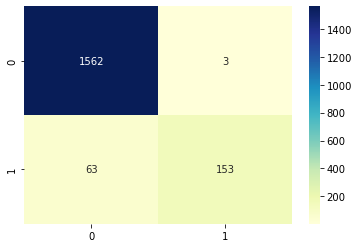

In [49]:
sns.heatmap(conf_mat, cmap='YlGnBu', annot=True, fmt='d');

Nella diagonale principale vengono visualizzate le predizioni corrette (1562 + 153) mentre nelle altre posizioni il nomero di volte che il modello ha predetto in modo errato (63 + 5).

Inoltre dalla matrice di confusione posso estrarre altre misure di performance importanti come la **precision** e la **recall**. Esiste una funzione, inclusa in sklearn, chiamata F1-score che descrive in una misura unica il valore della precision e della recall facendone una media aritmonica tra le due.

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [51]:
# precision of malicious website class
precision_score(y, y_pred, pos_label=1)

0.9807692307692307

In [52]:
# recall of malicious website class
recall_score(y, y_pred, pos_label=1)

0.7083333333333334

In [53]:
# f1-score of both classes
print("F1-score of benign website class: ", f1_score(y, y_pred, pos_label=0))
print("F1-score of malicious website class: ", f1_score(y, y_pred, pos_label=1))

F1-score of benign website class:  0.9793103448275862
F1-score of malicious website class:  0.8225806451612903


In [54]:
print("Average F1-score: ", f1_score(y, y_pred, average='macro'))

Average F1-score:  0.9009454949944382


**F1-score** è la metrica più esplicativa della bontà di un modello di classificazione, soprattutto quando si ha un dataset sbilanciato come il nostro.

Posso concludere che il modello funziona generalmente molto bene.

## SVM

Ora addestriamo un modello basato sull'algoritmo SVM, in particolare SVC (Support Vector Classifier). In letteratura funziona molto bene ed in generale e' il piu' performante.

In [55]:
from sklearn.svm import SVC

model4 = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric",     StandardScaler(), numeric_vars),
        ("categorical", OneHotEncoder(handle_unknown='ignore'),  categorical_vars)
    ])),
    ("svm", SVC())
])

grid = {
    "svm__C": [0.001,0.1,10,100,1000],
    "svm__gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "svm__kernel": ["rbf"]
}

gs = GridSearchCV(model4, param_grid=grid, cv=skf)

gs.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['url_length',
                                                                          'number_special_characters',
                                                                          'tcp_conversation_exchange',
                                                                          'dist_remote_tcp_port',
                                                                          'remote_ips',
                                                                          'app_bytes',
                                                                          'source_app_packets',
                                                                          'remote_app_packets',
                                                                          'source_app_bytes',
                                                                          'remote_app_bytes',
                                                                          'app_packets',
                                                                          'dns_query_times',
                                                                          'regdate_ts',
                                                                          'upd_ts']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['charset',
                                                                          'server',
                                                                          'whois_country',
                                                                          'whois_statepro'])])),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.001, 0.1, 10, 100, 1000],
                         'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svm__kernel': ['rbf']})

In [56]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__gamma,param_svm__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,0.036109,0.001158,0.010361,0.000487,100,0.1,rbf,"{'svm__C': 100, 'svm__gamma': 0.1, 'svm__kerne...",0.966387,0.971910,0.966292,0.980337,0.974719,0.971929,0.005310,1
21,0.037100,0.002770,0.010374,0.000487,1000,0.1,rbf,"{'svm__C': 1000, 'svm__gamma': 0.1, 'svm__kern...",0.963585,0.971910,0.966292,0.980337,0.974719,0.971369,0.005972,2
11,0.038291,0.001488,0.010765,0.000398,10,0.1,rbf,"{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel...",0.974790,0.963483,0.963483,0.977528,0.977528,0.971362,0.006511,3
17,0.034493,0.001354,0.008985,0.000012,100,0.01,rbf,"{'svm__C': 100, 'svm__gamma': 0.01, 'svm__kern...",0.966387,0.966292,0.963483,0.971910,0.980337,0.969682,0.005988,4
23,0.037482,0.001964,0.008987,0.000014,1000,0.001,rbf,"{'svm__C': 1000, 'svm__gamma': 0.001, 'svm__ke...",0.963585,0.960674,0.955056,0.963483,0.977528,0.964065,0.007409,5


**SVC** riesce ad ottenere una accuratezza molto alta (oltre ad un valore alto di precision, recall e f1-score calcolati sotto). L'accuratezza media ottenuta e' del 97%. Sembra essere il miglior modello da me addestrato in questo notebook.

In [57]:
print(gs.best_params_)

{'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [58]:
print(gs.best_estimator_)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['url_length',
                                                   'number_special_characters',
                                                   'tcp_conversation_exchange',
                                                   'dist_remote_tcp_port',
                                                   'remote_ips', 'app_bytes',
                                                   'source_app_packets',
                                                   'remote_app_packets',
                                                   'source_app_bytes',
                                                   'remote_app_bytes',
                                                   'app_packets',
                                                   'dns_query_times',
                                                   'regdate_ts', 'upd_ts']),
              

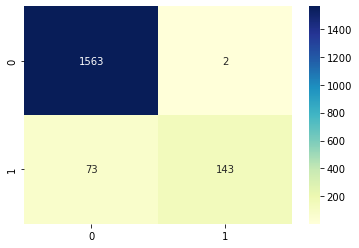

In [59]:
y_pred = cross_val_predict(model4, X, y, cv=skf)
conf_mat = confusion_matrix(y, y_pred)
sns.heatmap(conf_mat, cmap='YlGnBu', annot=True, fmt='d');

La matrice di confusione conferma che il modello funziona molto bene.

In [60]:
# precision of malicious website class
precision_score(y, y_pred, pos_label=1)

0.9862068965517241

In [61]:
# recall of malicious website class
recall_score(y, y_pred, pos_label=1)

0.6620370370370371

In [62]:
# f1-score of both classes
print("F1-score of benign website class: ", f1_score(y, y_pred, pos_label=0))
print("F1-score of malicious website class: ", f1_score(y, y_pred, pos_label=1))

F1-score of benign website class:  0.9765698219306466
F1-score of malicious website class:  0.7922437673130193


In [63]:
print("Average F1-score: ", f1_score(y, y_pred, average='macro'))

Average F1-score:  0.8844067946218329


## SVM with SMOTE

A questo punto mi rimane l'applicazione dell'oversampling dei dati, generando nuove instanze artificiale alla classe meno presente (ovvero i siti web maligni). Per questo utilizzo una libreria molto famosa di nome SMOTE.
Vediamo se i risultati migliorano ulteriormente:

In [64]:
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

model5 = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric",     StandardScaler(), numeric_vars),
        ("categorical", OneHotEncoder(handle_unknown='ignore'),  categorical_vars)
    ])),
    ("smote", SMOTE(random_state=1)),
    ("svm", SVC())
])

grid = {
    "svm__C": [0.001,0.1,10,100,1000],
    "svm__gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "svm__kernel": ["rbf"]
}

gs = GridSearchCV(model5, param_grid=grid, cv=skf)

gs.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['url_length',
                                                                          'number_special_characters',
                                                                          'tcp_conversation_exchange',
                                                                          'dist_remote_tcp_port',
                                                                          'remote_ips',
                                                                          'app_bytes',
                                                                          'source_app_packets',
                                                                          'remote_app_packets',
                                                                          'source_app_bytes',
                                                                          'remote_app_bytes',
                                                                          'app_packets',
                                                                          'dns_query_times',
                                                                          'regdate_ts',
                                                                          'upd_ts']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['charset',
                                                                          'server',
                                                                          'whois_country',
                                                                          'whois_statepro'])])),
                                       ('smote', SMOTE(random_state=1)),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.001, 0.1, 10, 100, 1000],
                         'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svm__kernel': ['rbf']})

In [65]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__gamma,param_svm__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.170344,0.003645,0.011569,0.000489,10,0.1,rbf,"{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel...",0.966387,0.969101,0.960674,0.980337,0.977528,0.970805,0.007227,1
21,0.163562,0.003611,0.010964,0.000613,1000,0.1,rbf,"{'svm__C': 1000, 'svm__gamma': 0.1, 'svm__kern...",0.969188,0.966292,0.969101,0.971910,0.969101,0.969118,0.001777,2
16,0.165357,0.005478,0.011170,0.000978,100,0.1,rbf,"{'svm__C': 100, 'svm__gamma': 0.1, 'svm__kerne...",0.969188,0.966292,0.969101,0.971910,0.969101,0.969118,0.001777,2
20,0.413617,0.005624,0.030326,0.000808,1000,1,rbf,"{'svm__C': 1000, 'svm__gamma': 1, 'svm__kernel...",0.957983,0.969101,0.957865,0.955056,0.966292,0.961260,0.005432,4
15,0.414300,0.007919,0.030114,0.001153,100,1,rbf,"{'svm__C': 100, 'svm__gamma': 1, 'svm__kernel'...",0.957983,0.969101,0.957865,0.955056,0.966292,0.961260,0.005432,4


In [66]:
print(gs.best_params_)

{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


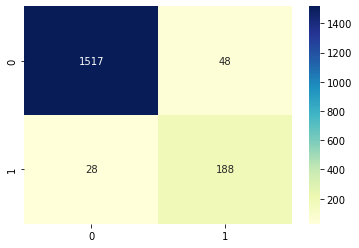

In [67]:
y_pred = cross_val_predict(model5, X, y, cv=skf)
conf_mat = confusion_matrix(y, y_pred)
sns.heatmap(conf_mat, cmap='YlGnBu', annot=True, fmt='d');

In [68]:
# precision of malicious website class
precision_score(y, y_pred, pos_label=1)

0.7966101694915254

In [69]:
# recall of malicious website class
recall_score(y, y_pred, pos_label=1)

0.8703703703703703

In [70]:
print("Average F1-score: ", f1_score(y, y_pred, average='macro'))

Average F1-score:  0.9037105540221382


L'accuratezza rimane praticamente la stessa (97%) mentre migliora di qualche punto la f1-score  e il modello sbaglia meno frequentemente quando deve classificare i siti web maligni. In pratica gli errori vengono bilanciati gli errori che commette su entrambe le classi. C'e' un bilanciamento anche per quando riguarda la precision, che si abbassa ma la recall che si alza.

## Features Importance
Interessante e' anche vedere quali solo le variabili effettivamente piu' importanti che il modello ha selezionato per prendere le proprie decisioni. Questo e' pero' complicato farlo con metodi convenzionali su modelli di classificazione come la Random Forest e Support Vector Machine, per cui una soluzione puo' essere utilizzare la libreria **SHAP** che consente di ottenere informazioni basate su meccanismi di *interpretability* anche su modelli non esplicitamente interpretabili. 

*Riaddestro un nuovo modello **RandomForestClassifier** con gli iperparametri migliori calcolati sopra con la grid search cv per semplificare un po' le cose*

In [71]:
from sklearn.inspection import permutation_importance

In [72]:
data_numeric = data.drop(categorical_vars, axis=1)
data_numeric = data_numeric.drop("url", axis=1)

X = data_numeric.drop("type", axis=1)
y = data["type"]

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X, y, test_size=0.33, random_state=1)

rfc = RandomForestClassifier(class_weight={0: 1, 1: 5}, max_depth=9, max_features='sqrt', max_leaf_nodes=9, n_estimators=150, random_state=42)
rfc.fit(X_train_num, y_train_num)

RandomForestClassifier(class_weight={0: 1, 1: 5}, max_depth=9, max_leaf_nodes=9,
                       n_estimators=150, random_state=42)

In [76]:
import shap

In [77]:
interpreter = shap.TreeExplainer(rfc)
shap_values = interpreter.shap_values(X_test_num)

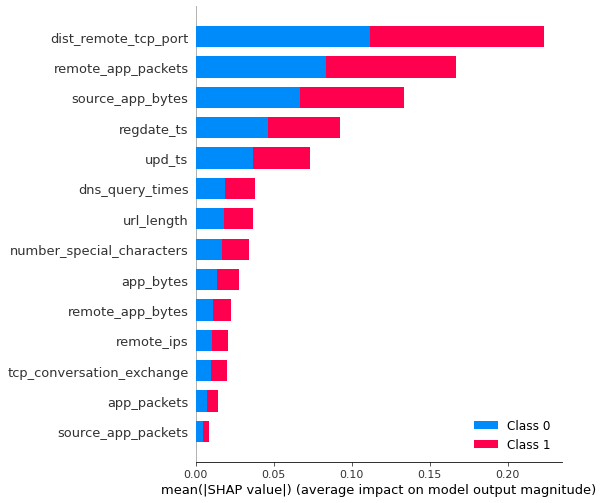

In [79]:
shap.summary_plot(shap_values, X_test_num, feature_names=X.columns)

In questo grafico vengono mostrate le features piu' rilevanti per la predizione del modello. La Shap value misura l'importanza di ogni variabile (positiva verso destra, negativa verso sinistra) mentre il colore rappresenta la tendenza verso malign website (rosso) o benign website (blu). 

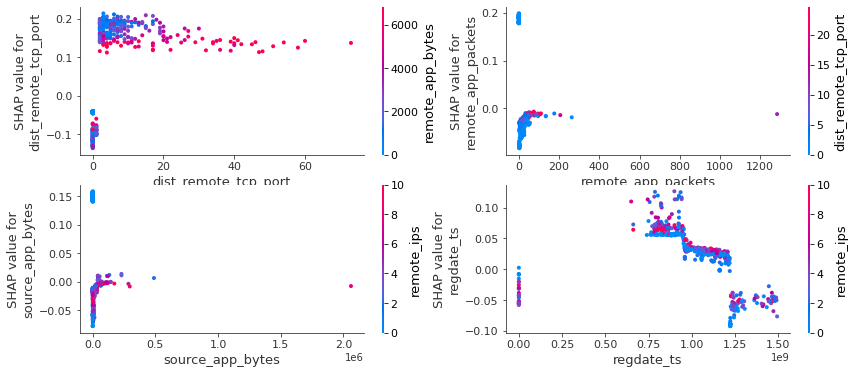

In [90]:
fig, axes = plt.subplots(2, 2, figsize = (14,6))

shap.dependence_plot("dist_remote_tcp_port", shap_values[0], X_test_num, feature_names=X.columns, ax=axes[0,0], show = False)
shap.dependence_plot("remote_app_packets", shap_values[0], X_test_num, feature_names=X.columns, ax=axes[0,1], show = False)
shap.dependence_plot("source_app_bytes", shap_values[0], X_test_num, feature_names=X.columns, ax=axes[1,0], show = False)
shap.dependence_plot("regdate_ts", shap_values[0], X_test_num, feature_names=X.columns, ax=axes[1,1], show = False)

plt.show()

Con questi grafici sono andato ad analizzare piu' in specifico le prime 4 features piu' importanti per il modello. Si puo' notare, ad esempio, che la data di registrazione del server e' solitamente piu' recente nei casi si siti web maligni. Oppure che i siti web maligni hanno un numero di porte identificate come non TCP maggiore.

## Conclusioni
Termino il notebook con qualche personale conclusione:
* Sono partito cercando analizzare e trasformare le variabili del dataset nel modo migliore possibile, trasformando quelle che potevano contenere informazioni utili ed eliminando quelle inultili o senza nessuna correlazione con le altre.
* Ho addestrato inizialmente due modelli piu' semplici senza utilizzare tecniche particolari di traformazione e manipolazione dei dati per vedere quanto potessero funzionare bene e meno sul mio dataset. I risultati mostrano che gia' **Perceptron** e **Logistic Regression** non funzionano poi cosi' male gia' da subito.
* Infine ho addestrato due modelli molto famosi applicando tecniche piu' sofisticate come la Stratified K-Fold Cross Validation, il Tuning degli iperparametri, la valutazione del modello non solo basandosi sulla sua accuratezza ma anche calcolando altre metriche (la precision, la recall e f1-score) e l'analisi di quanto sbaglia o no il modello plottando la matrice di confusione. Ho inoltre applicato a SVC una tecnica di oversampling (data augmentation) per bilanciare le due classi.
 * **Random Forest Classifier**: il modello funziona molto bene sui dati arrivando ad avere un'accuratezza del 95%, precision = 0.98, recall = 0.70, average f1-score = 0.90. 
 * **SVC**: con smote applicato ai dati e' il modello migliore con un'accuratezza del 97%, precision = 0.98, recall = 0.66, average f1-score = 0.90. Inoltre i tempi di addestramento sono minori rispetto alla random forest, proprio per la natura dell'algoritmo.
* Confrontando i due modelli migliori: **SVC** ha un'accuratezza migliore e tempi di addestramento minori, f1-score e' praticamente identico. **Random forest**, invece, ha un'accuratezza minore ed e' anche piu' lento nell'addestramento, l'f1-score e' uguale a **SVC**.
 
Confrontando i miei risultati con quelli che si trovano online su Kaggle sono mediamente piu' buoni, anche se e' difficile da dire perche' molti di loro non utilizzano tecniche da me utilizzate come la Stratified K-fold cross validation, il tuning degli iperparametri per trovare quelli migliori ed altre accortezze implementete in questo notebook come il One Hot Encoding e Oversampling della classe minore. 
 
Personalmente mi ritengo soddisfatto dei risultati ottenuti.